## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Wetland Methane Emissions, LPJ-EOSIM Model data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.
   

## About the Data

Methane (CH₄) emissions from vegetated wetlands are estimated to be the largest natural source of methane in the global CH₄ budget, contributing to roughly one third of the total of natural and anthropogenic emissions. Wetland CH₄ is produced by microbes breaking down organic matter in the oxygen deprived environment of inundated soils. Due to limited data availability, the details of the role of wetland CH₄ emissions have thus far been underrepresented. Using the Earth Observation SIMulator version (LPJ-EOSIM) of the Lund-Potsdam-Jena Dynamic Global Vegetation Model (LPJ-DGVM) global CH₄ emissions from wetlands are estimated at 0.5° x 0.5 degree spatial resolution. By simulating wetland extent and using characteristics of inundated areas, such as wetland soil moisture, temperature, and carbon content, the model provides estimates of CH₄ quantities emitted into the atmosphere. This dataset shows concentrated methane sources from tropical and high latitude ecosystems. The LPJ-EOSIM Wetland Methane Emissions dataset consists of global daily model estimates of terrestrial wetland methane emissions from 1990 to the present, with data added bimonthly. The estimates are regularly used in conjunction with NASA’s Goddard Earth Observing System (GEOS) model to simulate the impact of wetlands and other methane sources on atmospheric methane concentrations, to compare against satellite and airborne data, and to improve understanding and prediction of wetland emissions.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "http://ghg.center/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://ghg.center/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for the wetland methane emissions LPJ-EOSIM Model
collection_name = "lpjeosim-wetlandch4-daygrid-v2"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
asset_name = "ensemble-mean-ch4-wetlands-emissions"

In [ ]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

Examining the contents of our `collection` under `summaries`, we see that the data is available from January 1980 to December 2021. By looking at `dashboard: time density`, we can see that these observations are collected monthly.

In [4]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"

def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
        
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]
        # temp = items_url.split('/')
        # temp.insert(3, 'ghgcenter')
        # temp.insert(4, 'api')
        # temp.insert(5, 'stac')
        # items_url = '/'.join(temp)

    # Return the information about the total number of granules found associated with the collection
    return count

In [5]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 600 items


In [ ]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [7]:
# Fetch the minimum and maximum values for rescaling
rescale_values = {'max': 0.0003, 'min': 0.0}

## Explore Changes in Methane (CH4) Emission Levels Using the Raster API
In this notebook, we will explore the temporal impacts of methane emissions. We will visualize the outputs on a map using `folium`.


In [8]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:10]: item for item in items} 

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for date 1 mentioned in the next cell and again for date 2, so we can visualize each event independently.

In [9]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma" 

# Make a GET request to retrieve information for the date mentioned below
date1 = '2024-01-01'
date1_tile = requests.get(

    # Pass the collection name, collection date, and its ID
    # To change the year and month of the observed parameter, you can modify the "items['YYYY-MM-DD']" statement
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date1]['collection']}&item={items[date1]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return response in JSON format
).json()

# Print the properties of the retrieved granule to the console
date1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lpjeosim-wetlandch4-daygrid-v2&item=lpjeosim-wetlandch4-daygrid-v2-20240101day&assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [10]:
# Make a GET request to retrieve information for date mentioned below
date2 = '2024-01-30'
date2_tile = requests.get(

    # Pass the collection name, collection date, and its ID
    # To change the year and month of the observed parameter, you can modify the "items['YYYY-MM-DD']" statement
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date2]['collection']}&item={items[date2]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return response in JSON format 
).json()

# Print the properties of the retrieved granule to the console
date2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lpjeosim-wetlandch4-daygrid-v2&item=lpjeosim-wetlandch4-daygrid-v2-20240130day&assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualize CH₄ Emissions


In [11]:
# For this study we are going to compare the CH₄ Emissions in 2001 and 2021 along the coast of California
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set initial zoom and center of map
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# Define the first map layer for tile fetched for date 1
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_date1 = TileLayer(
    tiles=date1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_date1.add_to(map_.m1)


# Define the second map layer for the tile fetched for date 2
map_layer_date2 = TileLayer(
    tiles=date2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_date2.add_to(map_.m2)

# Visualize the Dual Map
map_


# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas, United States.

In [12]:
# The Area of Interest (AOI) is set to Texas (USA)
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [longitude, latitude]
                [-95, 29], # Southeast Bounding Coordinate
                [-95, 33], # Northeast Bounding Coordinate
                [-104, 33], # Northwest Bounding Coordinate
                [-104,29], # Southwest Bounding Coordinate
                [-95, 29] # Closing the polygon at the Southeast Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}

In [13]:
# Create a new map to display the generated polygon
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30,-101 # coordinates for the AOI in Texas, USA
    ],

    # Set the zoom value
    zoom_start=6, # zoom in or out by increasing or decreasing the value here
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [14]:
# Check the total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 600 items


In [ ]:
# Examine the first item in the collection
items[0]

Now we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [16]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (Texas polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the AOI boundaries to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (AOI polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above, we can generate the statistics for the area of interest.

In [17]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the AOI polygon
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 14.9 s, sys: 1.97 s, total: 16.9 s
Wall time: 4min 5s


In [18]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 0.0031482954509556293,
   'mean': 0.00022546476167109277,
   'count': 144.0,
   'sum': 0.03246692568063736,
   'std': 0.0005144286193682974,
   'median': 5.088370380690321e-05,
   'majority': 0.0,
   'minority': 0.0,
   'unique': 144.0,
   'histogram': [[119.0, 15.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0],
    [0.0,
     0.000314829550916329,
     0.000629659101832658,
     0.0009444886236451566,
     0.001259318203665316,
     0.0015741477254778147,
     0.0018889772472903132,
     0.002203806769102812,
     0.002518636407330632,
     0.002833465812727809,
     0.0031482954509556293]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 144.0,
   'percentile_2': 1.4471482018052484e-07,
   'percentile_98': 0.002311925734393298}},
 'datetime': '2024-02-27T00:00:00+00:00'}

In [19]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2024-02-27T00:00:00+00:00,0.0,0.003148,0.000225,144.0,0.032467,0.000514,0.000051,0.0,0.0,144.0,"[[119.0, 15.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0...",100.0,0.0,144.0,1.447148e-07,0.002312,2024-02-27 00:00:00+00:00
1,2024-02-26T00:00:00+00:00,0.0,0.003109,0.000225,144.0,0.032403,0.000516,0.000050,0.0,0.0,144.0,"[[119.0, 15.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0...",100.0,0.0,144.0,1.357729e-07,0.002320,2024-02-26 00:00:00+00:00
2,2024-02-25T00:00:00+00:00,0.0,0.003186,0.000230,144.0,0.033082,0.000534,0.000050,0.0,0.0,144.0,"[[119.0, 14.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...",100.0,0.0,144.0,1.308106e-07,0.002406,2024-02-25 00:00:00+00:00
3,2024-02-24T00:00:00+00:00,0.0,0.003323,0.000238,144.0,0.034300,0.000559,0.000050,0.0,0.0,144.0,"[[120.0, 13.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...",100.0,0.0,144.0,1.325920e-07,0.002523,2024-02-24 00:00:00+00:00
4,2024-02-23T00:00:00+00:00,0.0,0.003320,0.000242,144.0,0.034790,0.000566,0.000050,0.0,0.0,144.0,"[[120.0, 13.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...",100.0,0.0,144.0,1.359002e-07,0.002547,2024-02-23 00:00:00+00:00


## Visualize the Data as a Time Series
We can now explore the wetland methane emissions time series (January 1990 – December 2024) available for the Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'Daily CH4 emission Values for Texas, 1990-2024')

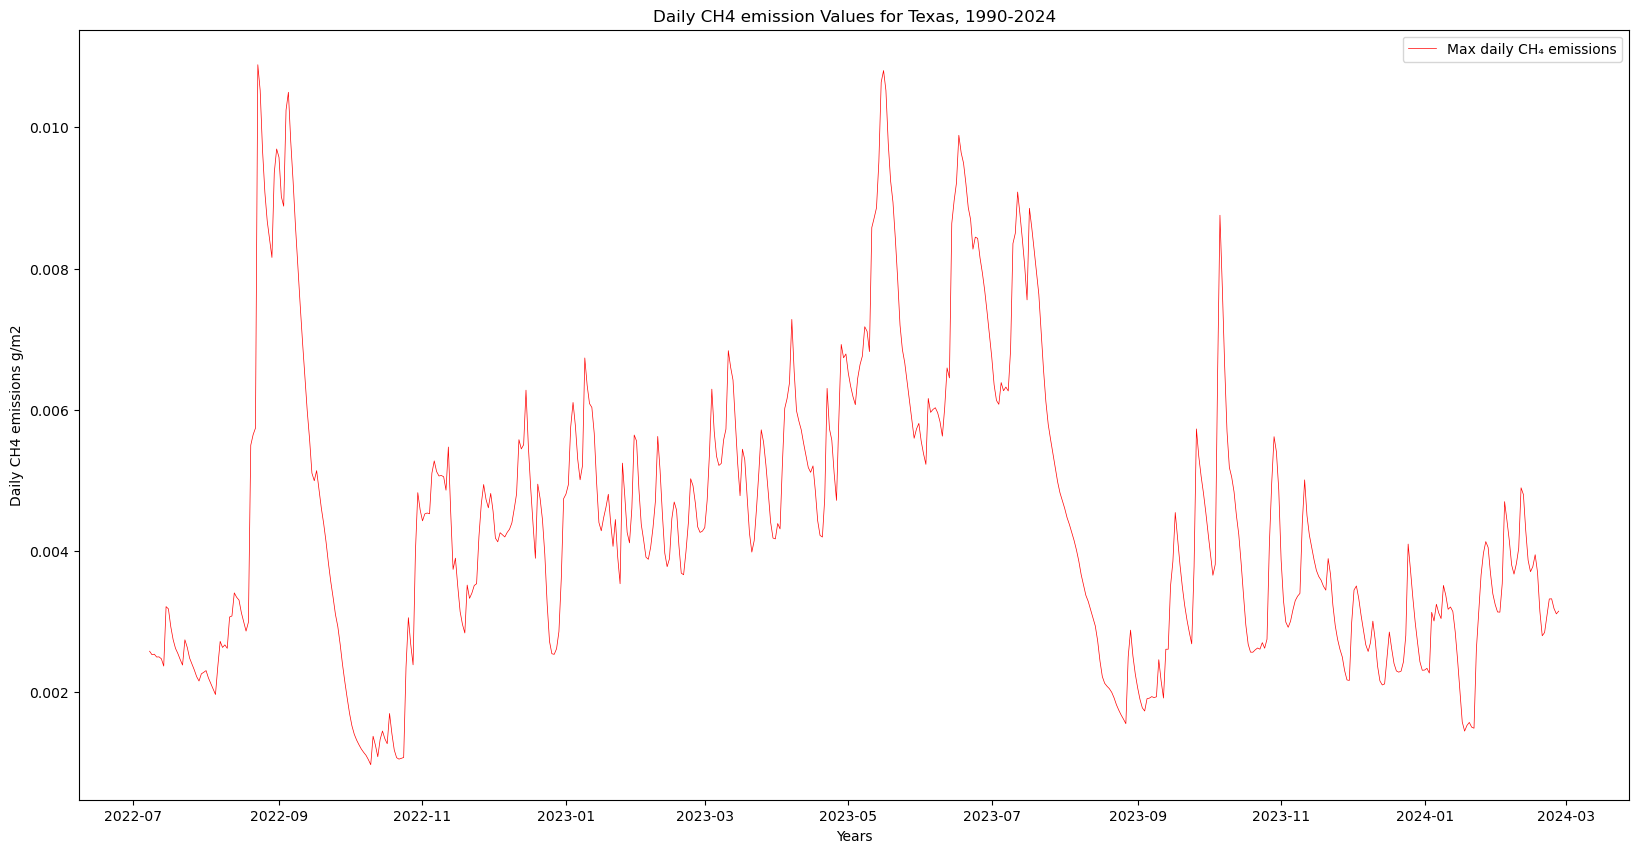

In [20]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

# Plot the time series
plt.plot(
    df["date"], # X-axis: date
    df["max"], # Y-axis: CH₄ value
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Max daily CH₄ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("Daily CH4 emissions g/m2")

# Insert title for the plot
plt.title("Daily CH4 emission Values for Texas, 1990-2024")

To take a closer look at the CH4 variability across this region, we are going to retrieve and display data collected during the October, 1990 observation.

In [21]:
# The 2024-02-25 observation is the 3rd item in the list
# Considering that a list starts with "0", we need to insert "2" in the "items[2]" statement
# Print the start Date Time of the third granule in the collection
print(items[2]["properties"]["datetime"])

2024-02-25T00:00:00+00:00


In [22]:
# A GET request is made for the 3rd item in the collection
observed_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
observed_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lpjeosim-wetlandch4-daygrid-v2&item=lpjeosim-wetlandch4-daygrid-v2-20240225day&assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [23]:
# Create a new map to display the CH4 variability for the Texas region for the October, 1990 timeframe
aoi_map_bbox = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Set the center of the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=8,
)

# Define the map layer
map_layer = TileLayer(
    tiles=observed_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", opacity = 0.5 # Set the attribution and transparency
)

# Add the layer to the map
map_layer.add_to(aoi_map_bbox)

# Visualize the map
aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the Daily Wetland Methane Emissions, LPJ-EOSIM Model data:
1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the CH4 levels over the Texas region for two distinctive years
5.  Create a table that displays the minimum, maximum, and sum of the CH4 levels for a specified region
6.  Generate a time-series graph of the CH4 levels for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).